# RAG (Retrieval-Augmented Generation) with Memory Tutorial

RAG combines two powerful concepts:
- **Retrieval**: Finding relevant information from your documents
- **Generation**: Using AI to answer questions based on that information

## Part 4: Generation
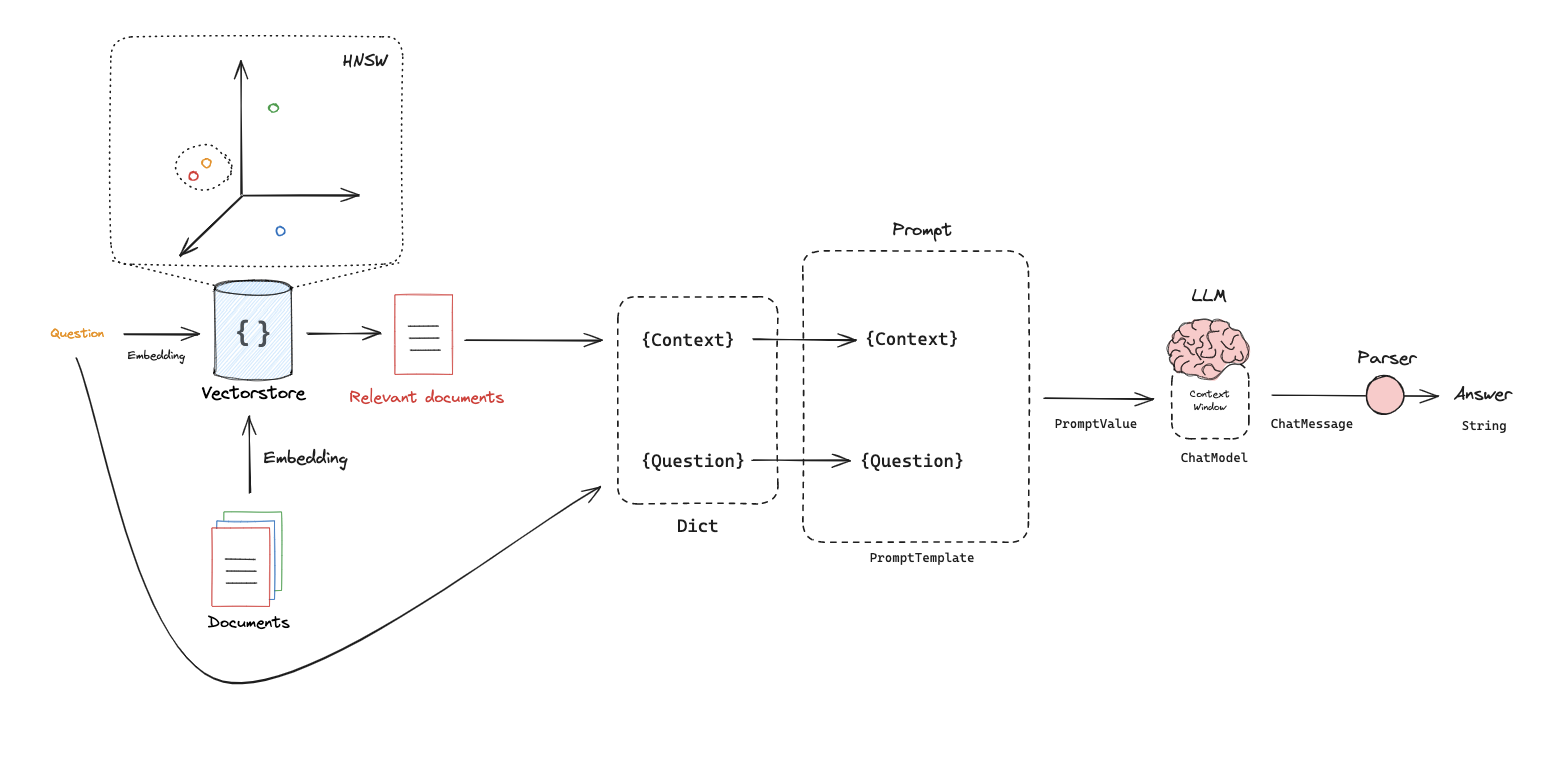

## What is Memory in RAG?
Memory allows the system to remember previous questions and answers in a conversation, so it can:
- Understand follow-up questions like "Why are those prerequisites needed?"
- Maintain context across multiple questions
- Provide more natural, conversational responses

## Tutorial Overview
1. Install required packages
2. Set up API keys
3. Load PDF documents
4. Split text into chunks
5. Create vector database
6. Build RAG chain with memory
7. Test with conversational examples

## Step 1: Install Required Packages

**Why do we need these packages?**
- `langchain_community`: Tools to work with different data sources (PDFs, databases, etc.)
- `langchain`: Main framework for building AI applications
- `pypdf`: Reads PDF files and extracts text
- `langchain-openai`: Connects to OpenAI's AI models
- `chromadb`: Stores text as vectors for fast similarity search

**How it works:**
Each package has a specific job in our RAG pipeline.

In [ ]:
# Install required packages
# langchain_community: Contains tools to work with different data sources
!pip install langchain_community

# langchain: Main framework for building AI applications
!pip install langchain

# pypdf: Helps us read PDF files
!pip install pypdf

# langchain-openai: Connects LangChain with OpenAI's models
!pip install langchain-openai

# chromadb: A database to store and search through text vectors
!pip install chromadb

print("✅ All packages installed successfully!")

## Step 2: Set Up Environment Variables

**Why do we need API keys?**
- OpenAI API key: Required to use OpenAI's language models for answering questions
- LangSmith API key: Optional tracking tool to see what happens behind the scenes

**How it works:**
Environment variables securely store your API keys so the code can access them without hardcoding secrets.

**⚠️ Important:** Replace the placeholder keys with your actual API keys!

In [ ]:
import os

# Set up tracking for LangChain (optional - helps you see what's happening behind the scenes)
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

# Replace 'your-langsmith-api-key' with your actual LangSmith API key (optional)
os.environ['LANGCHAIN_API_KEY'] = 'your-langsmith-api-key'

# ⚠️ IMPORTANT: Replace 'your-openai-api-key' with your actual OpenAI API key
os.environ['OPENAI_API_KEY'] = 'your-openai-api-key'

print("✅ Environment variables set up!")
print("Make sure you have replaced the API keys with your actual keys.")

## Step 3: Load PDF Documents

**Why do we load PDFs?**
- PDFs contain the knowledge we want our AI to use for answering questions
- We need to extract text from PDFs to make it searchable

**How it works:**
1. PyPDFLoader reads each PDF file
2. Extracts text from all pages
3. Creates document objects that contain the text and metadata
4. We intentionally add duplicates to show how RAG handles messy real-world data

**Example:**
If you have a 5-page PDF, PyPDFLoader creates 5 document objects, one for each page.

In [ ]:
# Import all the tools we need
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
import shutil
import os

# 📁 IMPORTANT: Update this path to where your PDF files are stored
# For Windows: r"C:\Users\YourName\Documents\PDFs"
# For Mac/Linux: "/Users/YourName/Documents/PDFs"
source_path = r"<your-source-path>"  # Change this to your actual folder path

print(f"📂 Looking for PDF files in: {source_path}")

# Create a list of PDF files to load
# Note: We're adding the same PDF twice on purpose to show how RAG handles duplicate content
loaders = [
    # First lecture PDF (added twice to simulate real-world messy data)
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture01.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture01.pdf")),  # Intentional duplicate!
    # Additional lecture PDFs
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture02.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture03.pdf"))
]

# Create an empty list to store all document pages
docs = []

print("📖 Loading PDF files...")

# Load each PDF and add its pages to our docs list
for i, loader in enumerate(loaders):
    try:
        # Each PDF might have multiple pages, so we extend (not append) the list
        current_docs = loader.load()
        docs.extend(current_docs)
        print(f"✅ Loaded PDF {i+1}: {len(current_docs)} pages")
    except Exception as e:
        print(f"❌ Error loading PDF {i+1}: {e}")

print(f"📊 Total pages loaded: {len(docs)}")

## Step 4: Split Text into Chunks

**Why do we split text?**
- Large documents are too big for AI models to process effectively
- Smaller chunks allow for more precise retrieval
- Each chunk can be independently searched and ranked

**How it works:**
- `chunk_size=1500`: Each piece is ~1500 characters (2-3 paragraphs)
- `chunk_overlap=150`: 150 characters overlap between chunks to maintain context
- RecursiveCharacterTextSplitter tries to split at natural boundaries (sentences, paragraphs)

**Example:**
```
Original: "Machine learning is... [3000 characters] ...very important."
After splitting:
Chunk 1: "Machine learning is... [1500 chars] ...algorithms work."
Chunk 2: "...algorithms work... [1500 chars] ...very important."
          ^overlap area^
```

In [ ]:
# Create a text splitter - this breaks large documents into smaller, manageable pieces
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,      # Each piece will be about 1500 characters (roughly 2-3 paragraphs)
    chunk_overlap=150     # 150 characters overlap between pieces to maintain context
)

print("✂️ Splitting documents into smaller chunks...")

# Split all documents into chunks
splits = text_splitter.split_documents(docs)

print(f"📄 Created {len(splits)} text chunks from {len(docs)} pages")
print(f"💡 This means each page was broken into ~{len(splits)//len(docs) if len(docs) > 0 else 0} chunks on average")

## Step 5: Create Vector Database

**Why do we create a vector database?**
- Computers can't directly search text for meaning
- Vectors (numbers) represent text meaning in a way computers can compare
- Similar texts have similar vectors, enabling semantic search

**How it works:**
1. `OpenAIEmbeddings()`: Converts text to vectors using OpenAI's embedding model
2. `Chroma.from_documents()`: Creates a database that stores text chunks and their vectors
3. The database can quickly find chunks similar to a query

**Example:**
```
Text: "Machine learning algorithms"
Vector: [0.1, 0.8, 0.3, 0.9, ...] (1536 numbers)

Query: "ML models"
Query Vector: [0.2, 0.7, 0.4, 0.8, ...]
→ Database finds similar vectors → Returns relevant chunks
```

In [ ]:
# Create embeddings object - this converts text into numbers (vectors) that computers can compare
embedding = OpenAIEmbeddings()

# Set up the vector database directory
persist_directory = 'docs/chroma/'

print("🧹 Cleaning up old database files...")

# Remove old database files if they exist (works on Windows, Mac, and Linux)
if os.path.exists(persist_directory):
    shutil.rmtree(persist_directory)
    print("✅ Old database removed")
else:
    print("ℹ️ No old database found")

# Alternate code to remove old database files
# !rmdir /s /q .\docs\chroma 

print("🔄 Creating vector database...")
print("This might take a few minutes as we convert text to vectors...")

# Create the vector database
vectordb = Chroma.from_documents(
    documents=splits,              # Our document chunks
    embedding=embedding,           # The embedding model to convert text to vectors
    persist_directory=persist_directory  # Where to save the database
)

print("✅ Vector database created successfully!")
print(f"📊 Total chunks stored in database: {vectordb._collection.count()}")

## Understanding the Two-Stage RAG Process

**Why do we need two stages?**
Regular RAG without memory fails on follow-up questions like "Why are those prerequisites needed?" because "those" is unclear without context.

**The Two Stages:**

### Stage 1: Query Reformulation (`history_aware_retriever`)
**Purpose:** Takes unclear questions + chat history → Creates clear search queries

**Example:**
- Chat history: "What is probability?" → "Probability is a measure of uncertainty..."
- User asks: "Why are those prerequisites needed?"
- Stage 1 reformulates to: "Why are probability prerequisites needed for machine learning?"

### Stage 2: Answer Generation (`question_answer_chain`)
**Purpose:** Takes retrieved documents + history + original question → Generates final answer

**Visual Flow:**
```
Chat History + User Question
           ↓
   [Stage 1: Query Reformulation]
           ↓
   Clear Query → Vector Database Search
           ↓
   Retrieved Documents
           ↓
   [Stage 2: Answer Generation]
           ↓
   Final Answer
```

**Why Not Just One Stage?**
- Without Stage 1: "Why are those prerequisites needed?" → Poor vector search → Bad results
- With Stage 1: "Why are those prerequisites needed?" → "Why are probability prerequisites needed for ML?" → Good vector search → Better results

## Step 6: Create History-Aware Retriever (Stage 1)

**Why do we need a history-aware retriever?**
- Regular retrievers can't understand follow-up questions
- This component reformulates vague questions into clear search queries
- It does NOT answer questions - only makes them clearer

**How it works:**
1. Takes chat history + current question
2. Uses AI to reformulate the question if needed
3. Searches vector database with the clear query
4. Returns relevant document chunks

**Key Setting:**
- `search_kwargs={"k": 3}`: Returns 3 most relevant chunks (you can adjust this)

In [ ]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage

# Initialize the LLM
llm = ChatOpenAI(temperature=0)

# Create a retriever - this automatically searches our database
retriever = vectordb.as_retriever(search_kwargs={"k": 3})  # Increased to k=3 for better context
print("🔍 Retriever created - it will automatically find relevant documents")
print("📊 Set to return 3 most relevant document chunks")

# Create history-aware retriever prompt
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

print("🧠 Creating history-aware retriever...")

# Create history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

print("✅ History-aware retriever created!")
print("💡 This component reformulates questions using chat history")

## Step 7: Create Question-Answer Chain (Stage 2)

**Why do we need a separate QA chain?**
- Stage 1 only reformulates questions - it doesn't answer them
- Stage 2 takes the retrieved documents and generates the actual answer
- This separation allows each stage to specialize in what it does best

**How it works:**
1. Receives relevant documents from Stage 1
2. Uses chat history for context
3. Generates educational, helpful answers
4. Admits when it doesn't know something

**Key Components:**
- `qa_system_prompt`: Instructions for how to answer questions
- `MessagesPlaceholder`: Handles chat history
- `create_stuff_documents_chain`: Combines documents with the prompt

In [ ]:
# Create QA prompt for the machine learning context
qa_system_prompt = (
    "You are an assistant helping students with machine learning concepts. "
    "Use the following pieces of retrieved context from the lecture materials to answer "
    "the question. If you don't know the answer based on the provided context, "
    "just say that you don't know. Keep your answers clear and educational.\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages([
    ("system", qa_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

print("📝 Creating question-answer chain...")

# Create document chain
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

print("🔗 Creating complete RAG chain with memory...")

# Create the complete RAG chain with history awareness
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

print("✅ History-aware RAG chain created successfully!")
print("🎯 This chain can now handle follow-up questions and maintain context")

## Step 8: Test the RAG Chain with Memory

**Why test with a conversation?**
- Memory functionality only shows up in multi-turn conversations
- Single questions don't demonstrate the history-aware capabilities
- Real users ask follow-up questions that reference previous context

**How the test works:**
1. `ask_question()` function handles each question
2. Stores both human questions and AI answers in `chat_history`
3. Each subsequent question can reference previous context
4. The system automatically reformulates unclear questions

**Test Sequence:**
- Question 1: Clear, standalone question
- Question 2: Follow-up using "those prerequisites" (references Q1)
- Question 3: Another follow-up using "specific example" (references Q2)

**Expected Behavior:**
The system should understand what "those prerequisites" refers to from the first question.

In [ ]:
# Initialize chat history
chat_history = []

# Example usage demonstrating memory preservation
def ask_question(question, chat_history):
    """Helper function to ask questions and maintain history"""
    print(f"\n❓ Question: {question}")
    
    result = rag_chain.invoke({
        "input": question,
        "chat_history": chat_history
    })
    
    answer = result["answer"]
    print(f"🤖 Answer: {answer}")
    
    # Add to history for context in future questions
    chat_history.extend([
        HumanMessage(content=question),
        AIMessage(content=answer)
    ])
    
    return answer

# Demo questions to show memory functionality
print("\n" + "="*60)
print("🚀 DEMO: Testing the RAG chain with memory")
print("="*60)

# First question - establishes context about probability
answer1 = ask_question("Is probability a class topic?", chat_history)

# Follow-up question that requires context from the first question
# "those prerequisites" refers to probability mentioned in the first question
answer2 = ask_question("Why are those prerequisites needed?", chat_history)

# Another follow-up that builds on previous context
# "specific example" refers to the explanation from the second question
answer3 = ask_question("Can you give me a specific example?", chat_history)

print("\n✅ Demo completed! The chain successfully maintained context across questions.")
print("💡 Notice how the follow-up questions reference previous context automatically.")

## Step 9: Alternative - Automatic Memory Management

**Why use RunnableWithMessageHistory?**
- Manual memory management (previous example) requires you to track chat_history
- This approach automatically handles memory for you
- Better for production applications where you don't want to manage history manually

**How it works:**
1. `ChatMessageHistory()`: Stores conversation history automatically
2. `session_id`: Unique identifier for each conversation (e.g., "user123_chat1")
3. `get_session_history()`: Retrieves or creates history for a session
4. No manual chat_history management needed

**Key Benefits:**
- Automatic memory management
- Session-based conversations
- Cleaner code for production use
- Multiple users can have separate conversations

**Use Cases:**
- Web applications with multiple users
- Chatbots that need to remember context
- Any application where manual memory management is inconvenient

In [ ]:
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

# Store for session histories - in production, this would be a database
store = {}

def get_session_history(session_id: str):
    """Get or create a chat history for a session"""
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

print("🔄 Setting up automatic memory management...")

# Wrap our RAG chain with automatic message history
conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

print("✅ Automatic memory management set up!")
print("\n" + "="*60)
print("🚀 DEMO: Testing automatic memory management")
print("="*60)

# First question with automatic history
question = "Is probability a class topic?"
print(f"\n❓ Question: {question}")

result = conversational_rag_chain.invoke(
    {"input": question},
    config={"configurable": {"session_id": "abc123"}}  # Session ID for this conversation
)

answer = result["answer"]
print(f"🤖 Answer: {answer}")

# Follow-up question - history is automatically managed
question = "Why are those prerequisites needed?"
print(f"\n❓ Question: {question}")

result = conversational_rag_chain.invoke(
    {"input": question},
    config={"configurable": {"session_id": "abc123"}}  # Same session ID
)

answer = result["answer"]
print(f"🤖 Answer: {answer}")

print("\n✅ Automatic memory management working perfectly!")
print("💡 No manual chat_history management needed!")

## Summary

**What we built:**
A complete RAG system with conversational memory that can:
- Load and process PDF documents
- Store text as searchable vectors
- Understand follow-up questions in context
- Maintain conversation history
- Provide accurate, educational answers

**Key Components:**
1. **Document Loading**: PyPDFLoader extracts text from PDFs
2. **Text Splitting**: Breaks large documents into manageable chunks
3. **Vector Database**: Stores text as searchable vectors using Chroma
4. **Two-Stage RAG**: Reformulates questions + generates answers
5. **Memory Management**: Maintains conversation context

**Two Memory Approaches:**
- **Manual**: You manage chat_history yourself (good for learning)
- **Automatic**: RunnableWithMessageHistory manages it for you (good for production)

**Next Steps:**
- Try with your own PDF documents
- Experiment with different chunk sizes
- Add more sophisticated prompts
- Deploy to a web application
- Add multiple data sources (web pages, databases, etc.)